### Image EDA for Stance Classification

This notebook performs exploratory data analysis on the image dataset
for multimodal stance classification on Gun Control and Abortion topics.

In [4]:
# Libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
from collections import Counter
import warnings
from wordcloud import WordCloud
import easyocr

warnings.filterwarnings('ignore')

#Arguments
augmented = False

In [5]:
# Paths
data_path = "../../data/"
img_path = "../../data/images"

if augmented:
  train_path = os.path.join(data_path,"train_augmented_synonym.csv")
else:
  train_path = os.path.join(data_path,"train.csv")

dev_path   = os.path.join(data_path,"dev.csv")
test_path  = os.path.join(data_path,"test.csv")

# Create output directory for plots
output_dir = "./eda_outputs/"
os.makedirs(output_dir, exist_ok=True)

#Load Data
train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)
test_df = pd.read_csv(test_path)

# Add split column if not present
if 'split' not in train_df.columns:
    train_df['split'] = 'train'
    dev_df['split'] = 'dev'
    test_df['split'] = 'test'

df = pd.concat([train_df, dev_df, test_df], ignore_index=True)
print(df.head())

              tweet_id                tweet_url  \
0  1148501065308004357  https://t.co/VQP1FHaWAg   
1  1103872992537276417  https://t.co/zsyXYSeBkp   
2  1151528583623585794  https://t.co/qSWvDX5MnM   
3  1100166844026109953  https://t.co/hxH8tFIHUu   
4  1021830413550067713  https://t.co/5whvEEtoQR   

                                          tweet_text   stance persuasiveness  \
0  Let's McGyver some Sanity in America!\n\nYou a...  support             no   
1  A child deserves a chance at life. A child des...   oppose             no   
2  Dear prolifers: girls as young as 10, 11, 12 a...  support             no   
3  The many States will attempt to amend their co...  support             no   
4  Every #abortion is wrong, no matter what metho...   oppose            yes   

   split  
0  train  
1  train  
2  train  
3  train  
4  train  


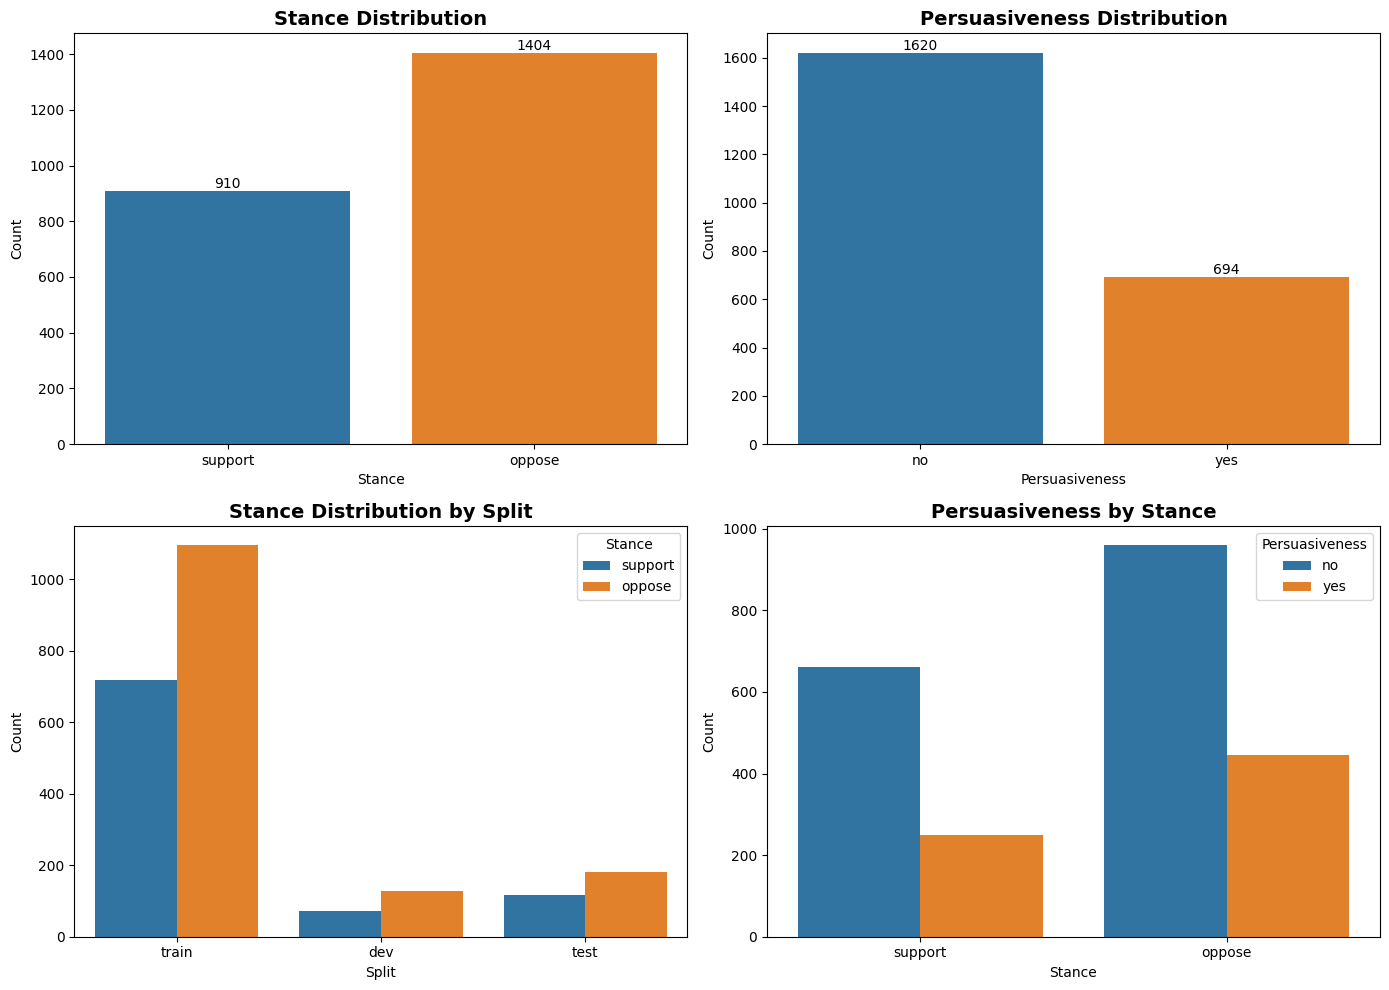

In [6]:
# Basic Statistics (Stance Dist, Persuasiveness Dist, Split Dist, Persuasiv by Stance)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Stance distribution
sns.countplot(data=df, x='stance', ax=axes[0, 0], hue='stance', legend=False)
axes[0, 0].set_title('Stance Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Stance')
axes[0, 0].set_ylabel('Count')
for p in axes[0, 0].patches:
    axes[0, 0].annotate(f'{int(p.get_height())}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom')

# Persuasiveness distribution
sns.countplot(data=df, x='persuasiveness', ax=axes[0, 1], hue='persuasiveness', legend=False)
axes[0, 1].set_title('Persuasiveness Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Persuasiveness')
axes[0, 1].set_ylabel('Count')
for p in axes[0, 1].patches:
    axes[0, 1].annotate(f'{int(p.get_height())}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom')

# Stance by split
sns.countplot(data=df, x='split', hue='stance', ax=axes[1, 0])
axes[1, 0].set_title('Stance Distribution by Split', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Split')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend(title='Stance')

# Persuasiveness by stance
sns.countplot(data=df, x='stance', hue='persuasiveness', ax=axes[1, 1])
axes[1, 1].set_title('Persuasiveness by Stance', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Stance')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend(title='Persuasiveness')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '01_label_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

In [7]:


# Image Availability


#Function to check if the image exists
def check_image_exists(tweet_id):
    image_path = os.path.join(img_path, f"{tweet_id}.jpg")
    return os.path.exists(image_path)

#We create the image path
def get_image_path(tweet_id):
    return os.path.join(img_path, f"{tweet_id}.jpg")


df['image_exists'] = df['tweet_id'].apply(check_image_exists)
df['image_path'] = df['tweet_id'].apply(get_image_path)

print(f"\n Proceeding with images found: {df['image_exists'].sum()} / {len(df)}")
df_with_images = df[df['image_exists']].copy()
df_with_images.head()


 Proceeding with images found: 2314 / 2314


tweet_id                tweet_url  \
0  1148501065308004357  https://t.co/VQP1FHaWAg   
1  1103872992537276417  https://t.co/zsyXYSeBkp   
2  1151528583623585794  https://t.co/qSWvDX5MnM   
3  1100166844026109953  https://t.co/hxH8tFIHUu   
4  1021830413550067713  https://t.co/5whvEEtoQR   

                                          tweet_text   stance persuasiveness  \
0  Let's McGyver some Sanity in America!\n\nYou a...  support             no   
1  A child deserves a chance at life. A child des...   oppose             no   
2  Dear prolifers: girls as young as 10, 11, 12 a...  support             no   
3  The many States will attempt to amend their co...  support             no   
4  Every #abortion is wrong, no matter what metho...   oppose            yes   

   split  image_exists                                 image_path  
0  train          True  ../../data/images/1148501065308004357.jpg  
1  train          True  ../../data/images/1103872992537276417.jpg  
2  train          True  ../../data/images/1151528583623585794.jpg  
3  train          True  ../../data/images/1100166844026109953.jpg  
4  train          True  ../../data/images/1021830413550067713.jpg

Processing all 2314 images...
Error processing ../../data/images/1163936804006977536.jpg: cannot identify image file '../../data/images/1163936804006977536.jpg'
Error processing ../../data/images/1290280312962940928.jpg: cannot identify image file '../../data/images/1290280312962940928.jpg'
Error processing ../../data/images/1200177857869336576.jpg: cannot identify image file '../../data/images/1200177857869336576.jpg'
Error processing ../../data/images/1370338056415289348.jpg: cannot identify image file '../../data/images/1370338056415289348.jpg'
Error processing ../../data/images/1324601823555104768.jpg: cannot identify image file '../../data/images/1324601823555104768.jpg'
Error processing ../../data/images/1354941521422905347.jpg: cannot identify image file '../../data/images/1354941521422905347.jpg'
Error processing ../../data/images/1366231979495153664.jpg: cannot identify image file '../../data/images/1366231979495153664.jpg'
Error processing ../../data/images/137588660555509760

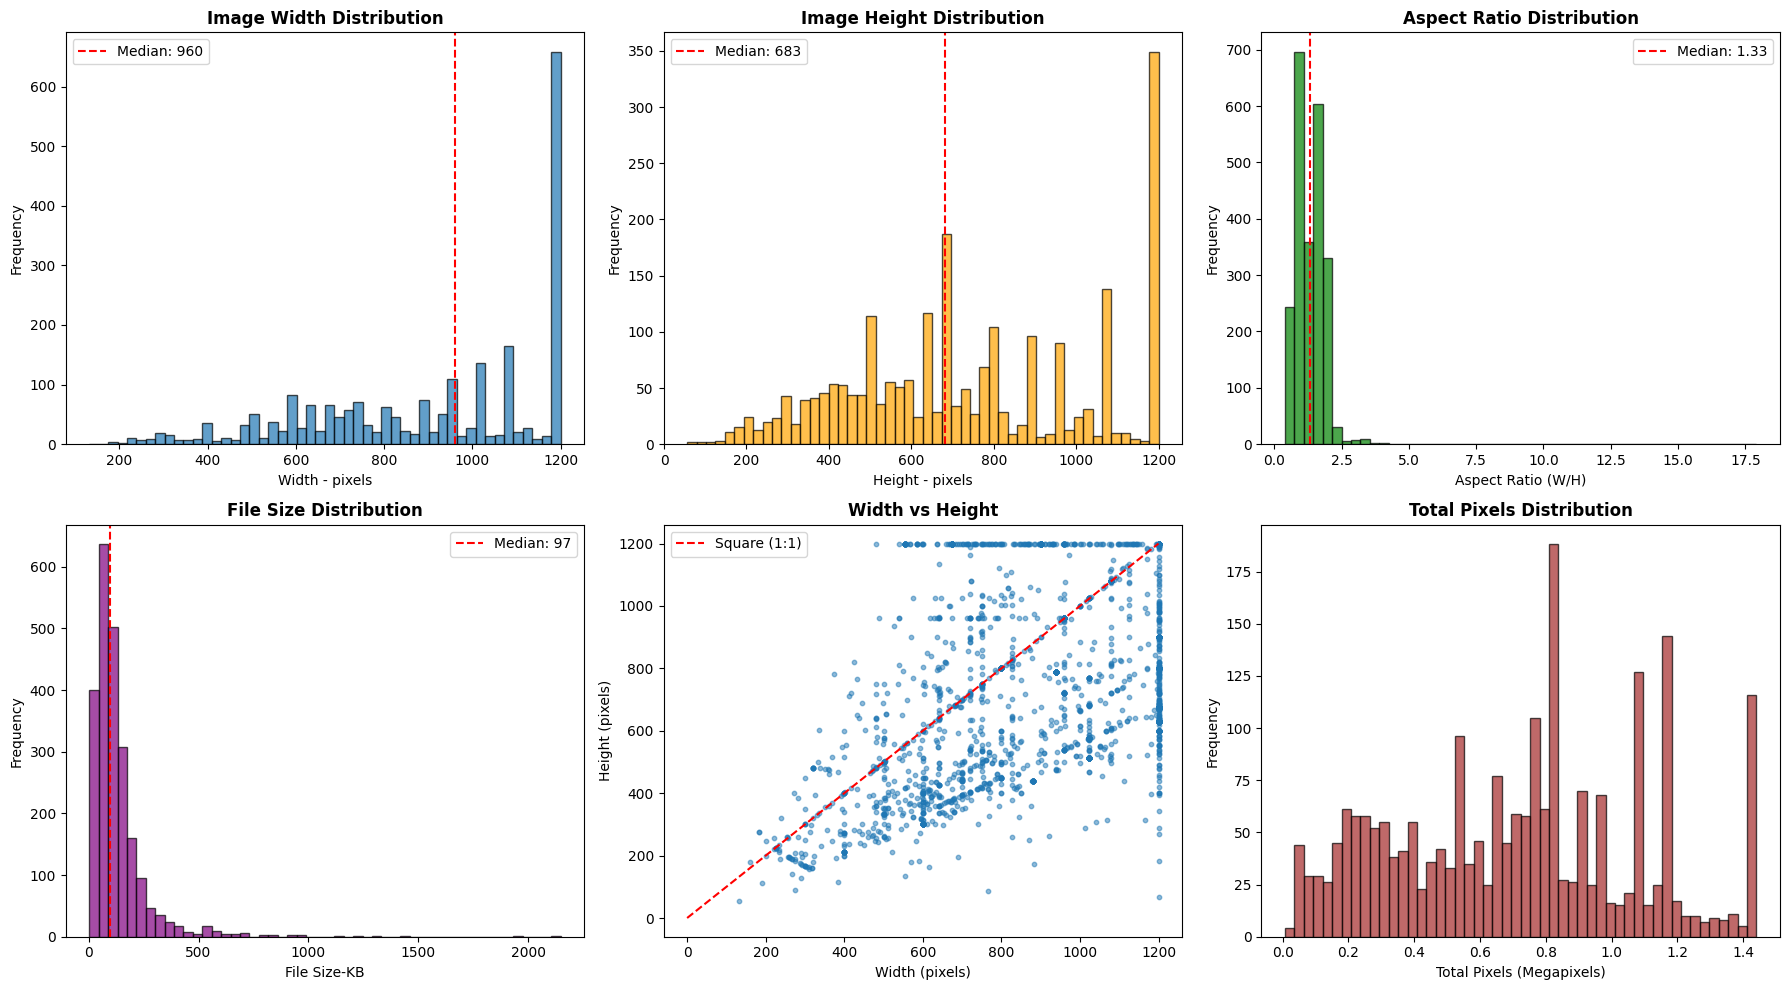

In [8]:
# Image properties Analysis (width, height, aspect ratio, model, file size)
def img_properties(image_path):
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            aspect_ratio = width / height if height > 0 else 0
            mode = img.mode
            file_size = os.path.getsize(image_path) / 1024  # KB
                
            return {'width': width,'height': height,'aspect_ratio': aspect_ratio,'mode': mode,
                    'file_size_kb': file_size,'total_pixels': width * height,'valid': True}
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return {'width': None,'height': None,'aspect_ratio': None,'mode': None,'file_size_kb': None,
                'total_pixels': None,'valid': False}
            
print(f"Processing all {len(df_with_images)} images...")
# Process all images
image_properties = df_with_images['image_path'].apply(img_properties)
props_df = pd.DataFrame(image_properties.tolist())

# We merge our datasets
df_with_images = pd.concat([df_with_images.reset_index(drop=True), props_df], axis=1)
df_with_images.head()


# Visualizations
df_valid = df_with_images[df_with_images["valid"]==True]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Width distribution
axes[0, 0].hist(df_valid['width'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Image Width Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Width - pixels')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df_valid['width'].median(), color='red', linestyle='--', label=f'Median: {df_valid["width"].median():.0f}')
axes[0, 0].legend()

# Height distribution
axes[0, 1].hist(df_valid['height'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Image Height Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Height - pixels')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df_valid['height'].median(), color='red', linestyle='--', label=f'Median: {df_valid["height"].median():.0f}')
axes[0, 1].legend()

# Aspect ratio distribution
axes[0, 2].hist(df_valid['aspect_ratio'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 2].set_title('Aspect Ratio Distribution', fontweight='bold')
axes[0, 2].set_xlabel('Aspect Ratio (W/H)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(df_valid['aspect_ratio'].median(), color='red', linestyle='--', label=f'Median: {df_valid["aspect_ratio"].median():.2f}')
axes[0, 2].legend()

# File size distribution
axes[1, 0].hist(df_valid['file_size_kb'], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].set_title('File Size Distribution', fontweight='bold')
axes[1, 0].set_xlabel('File Size-KB')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(df_valid['file_size_kb'].median(), color='red', linestyle='--', label=f'Median: {df_valid["file_size_kb"].median():.0f}')
axes[1, 0].legend()

# Width vs Height scatter
axes[1, 1].scatter(df_valid['width'], df_valid['height'], alpha=0.5, s=10)
axes[1, 1].set_title('Width vs Height', fontweight='bold')
axes[1, 1].set_xlabel('Width (pixels)')
axes[1, 1].set_ylabel('Height (pixels)')
axes[1, 1].plot([0, df_valid['width'].max()], [0, df_valid['width'].max()], 'r--', label='Square (1:1)')
axes[1, 1].legend()

# Total pixels distribution
axes[1, 2].hist(df_valid['total_pixels'] / 1e6, bins=50, edgecolor='black', alpha=0.7, color='brown')
axes[1, 2].set_title('Total Pixels Distribution', fontweight='bold')
axes[1, 2].set_xlabel('Total Pixels (Megapixels)')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '02_image_properties.png'), dpi=300, bbox_inches='tight')
plt.show()


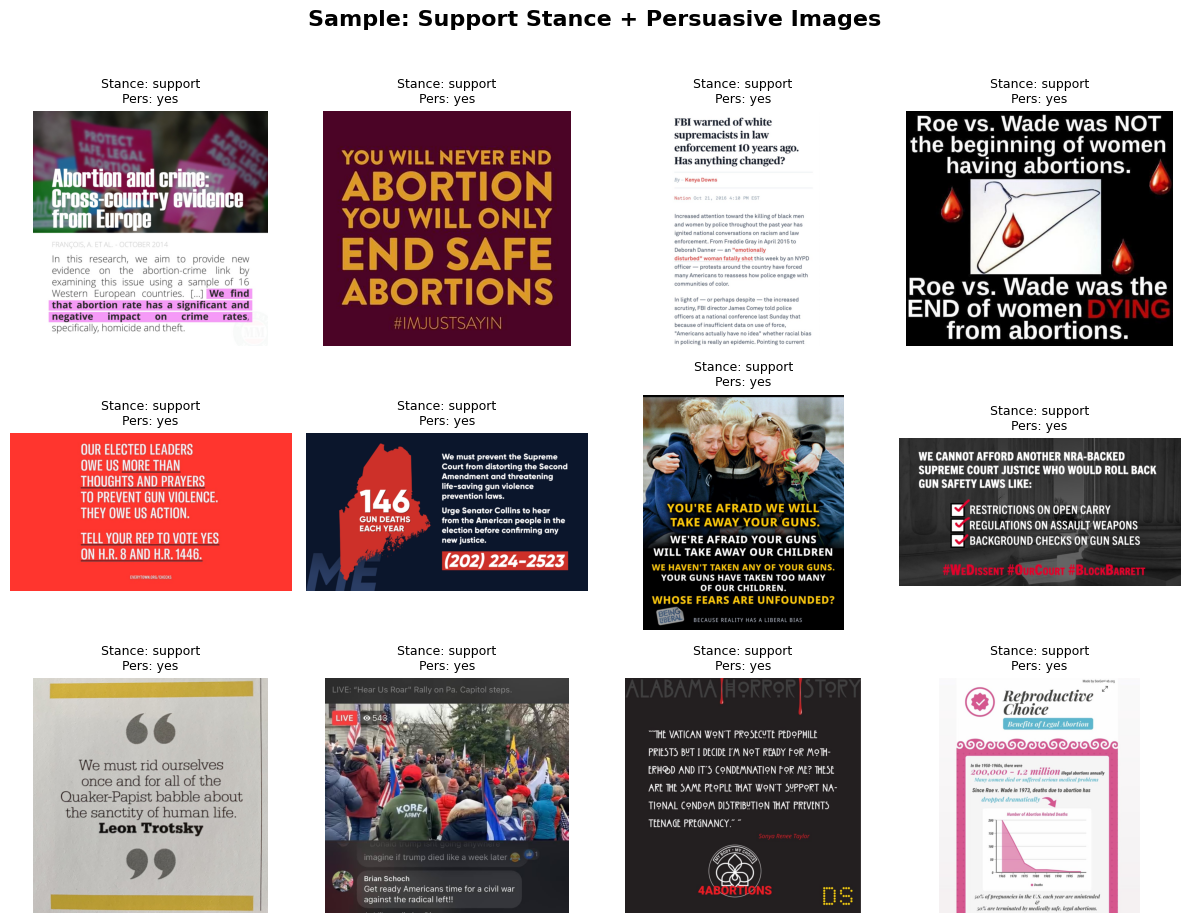

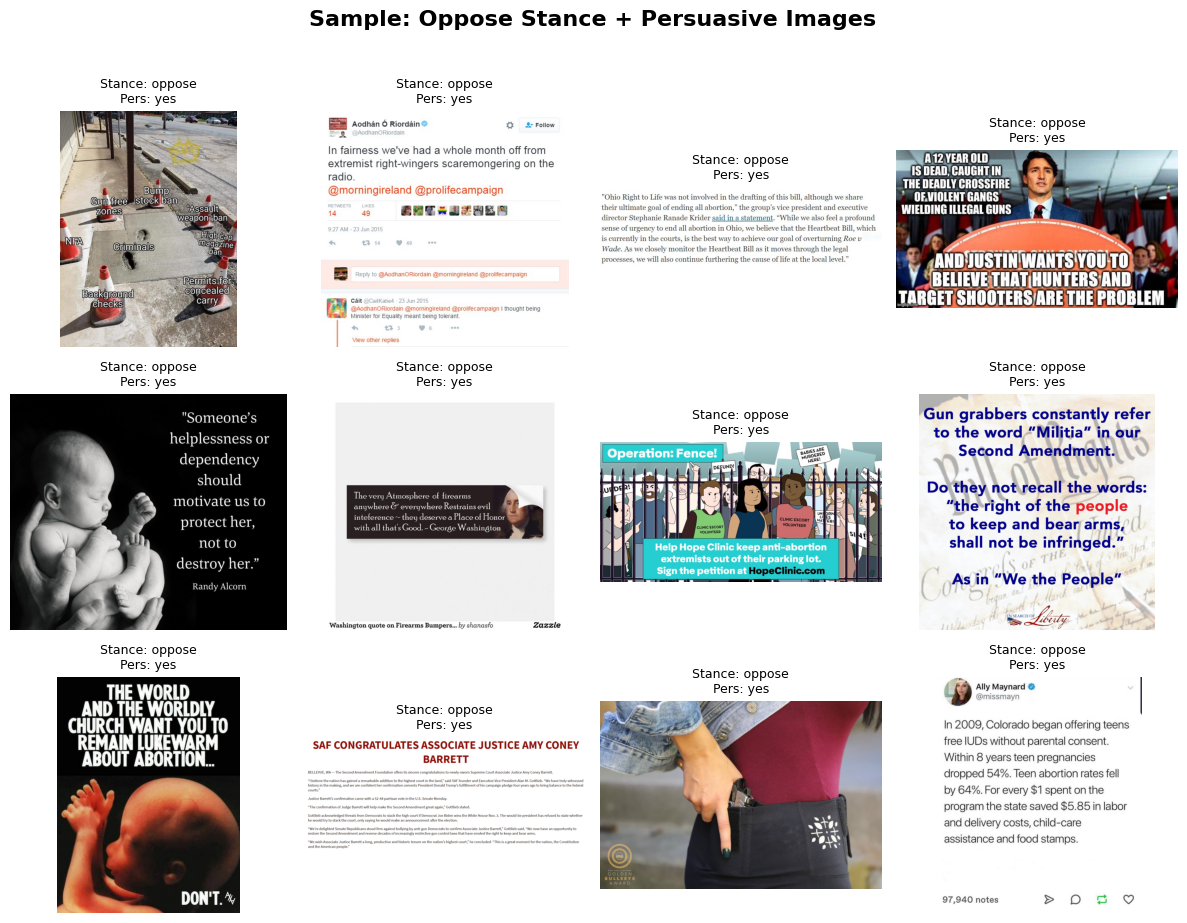

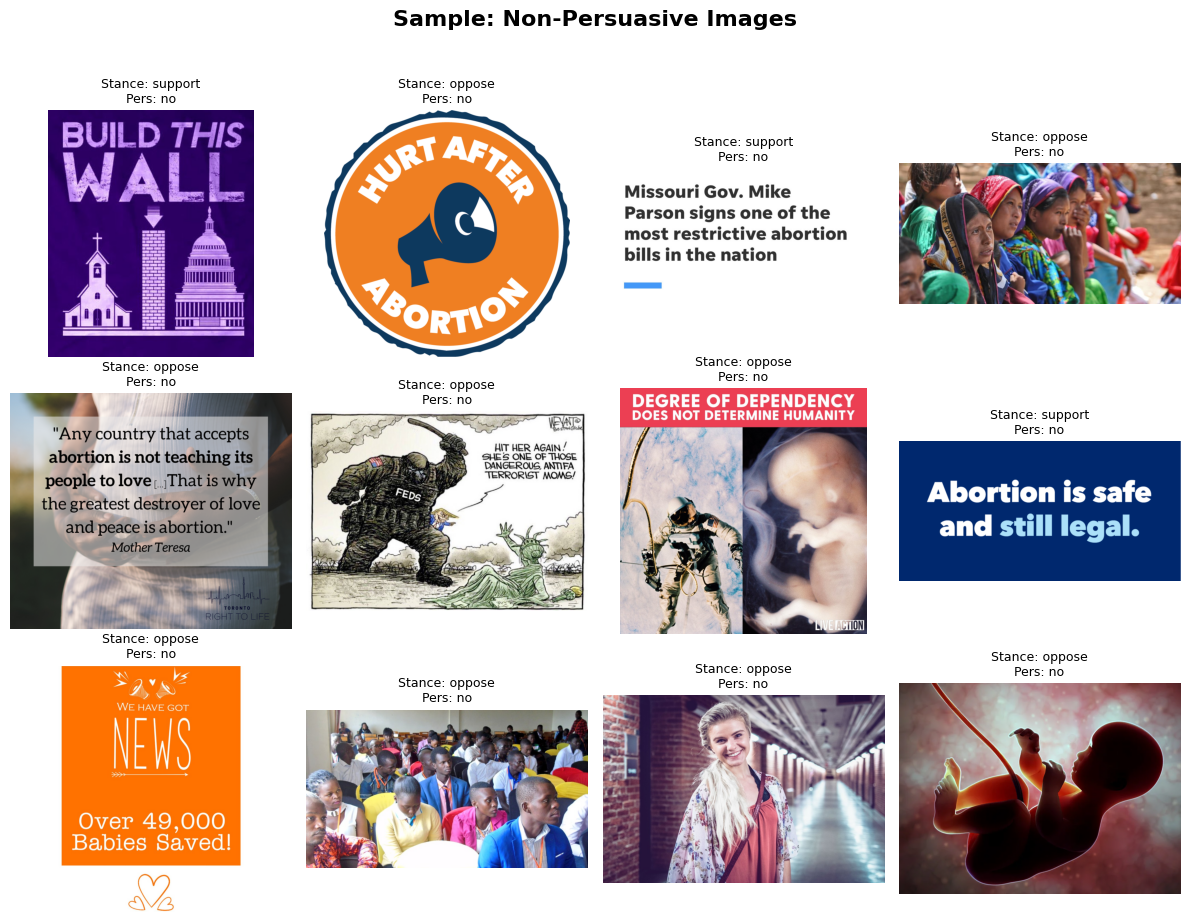

In [9]:
# Sample Image Visualtion per Stance


#Function to generate the grid of images
def img_grid(df, title, n_samples=12, cols=4):
    n_samples = min(n_samples, len(df))
    rows = (n_samples + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = axes.flatten() if n_samples > 1 else [axes]
    
    sample_df = df.sample(n=n_samples, random_state=42)
    
    for idx, (_, row) in enumerate(sample_df.iterrows()):
        if idx >= len(axes):
            break
            
        try:
            img = Image.open(row['image_path'])
            axes[idx].imshow(img)
            axes[idx].axis('off')
            title_text = f"Stance: {row['stance']}\nPers: {row['persuasiveness']}"
            axes[idx].set_title(title_text, fontsize=9)
        except Exception as e:
            axes[idx].text(0.5, 0.5, 'Error loading image', 
                          ha='center', va='center')
            axes[idx].axis('off')
    
    # Hide empty subplots
    for idx in range(n_samples, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig



#1. Support + Persuasive
support_persuasive = df_valid[(df_valid['stance'] == 'support') & 
                              (df_valid['persuasiveness'] == 'yes')]
fig = img_grid(support_persuasive, 'Sample: Support Stance + Persuasive Images')
plt.savefig(os.path.join(output_dir, '03_samples_support_persuasive.png'), dpi=150, bbox_inches='tight')
plt.show()


#2. Oppose + Persuasive
oppose_persuasive = df_valid[(df_valid['stance'] == 'oppose') & 
                             (df_valid['persuasiveness'] == 'yes')]
fig = img_grid(oppose_persuasive, 'Sample: Oppose Stance + Persuasive Images')
plt.savefig(os.path.join(output_dir, '04_samples_oppose_persuasive.png'), dpi=150, bbox_inches='tight')
plt.show()

# Non-persuasive
non_persuasive = df_valid[df_valid['persuasiveness'] == 'no']
fig = img_grid(non_persuasive, 'Sample: Non-Persuasive Images')
plt.savefig(os.path.join(output_dir, '05_samples_non_persuasive.png'), dpi=150, bbox_inches='tight')
plt.show()

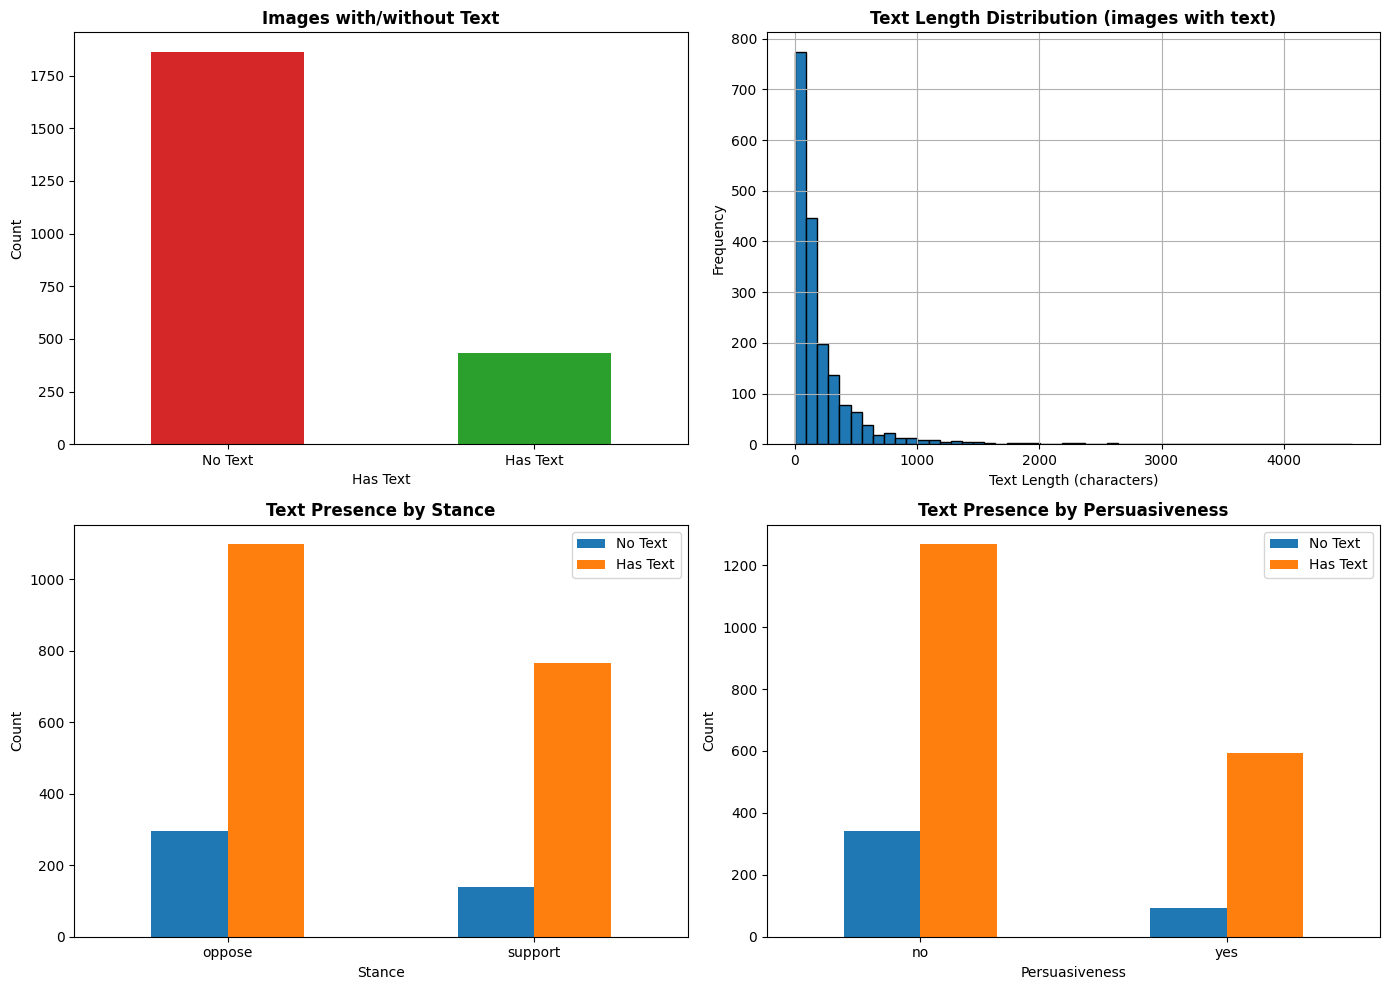

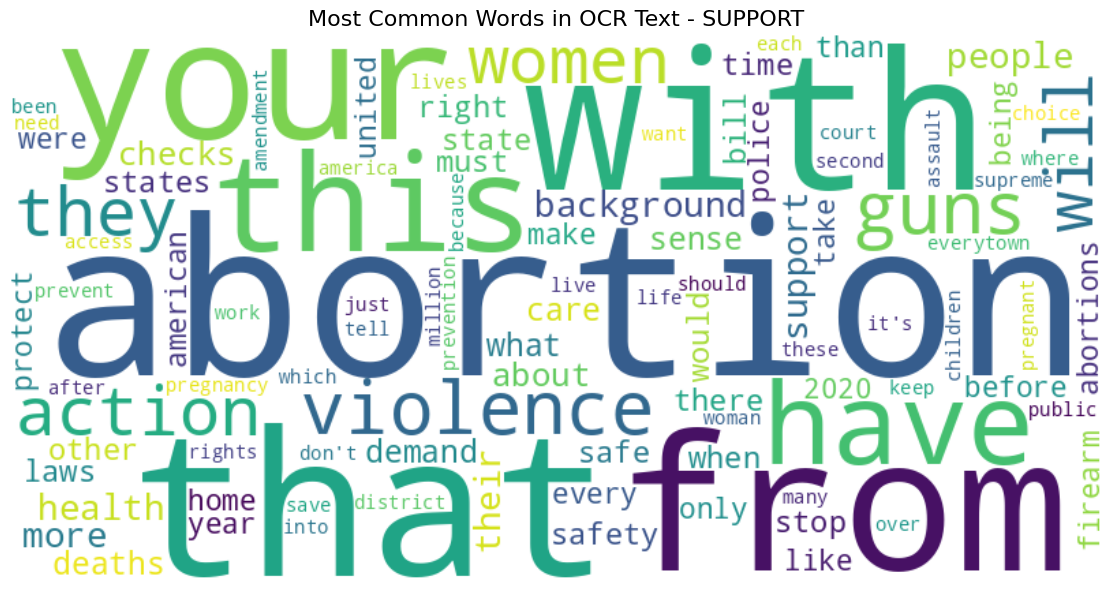

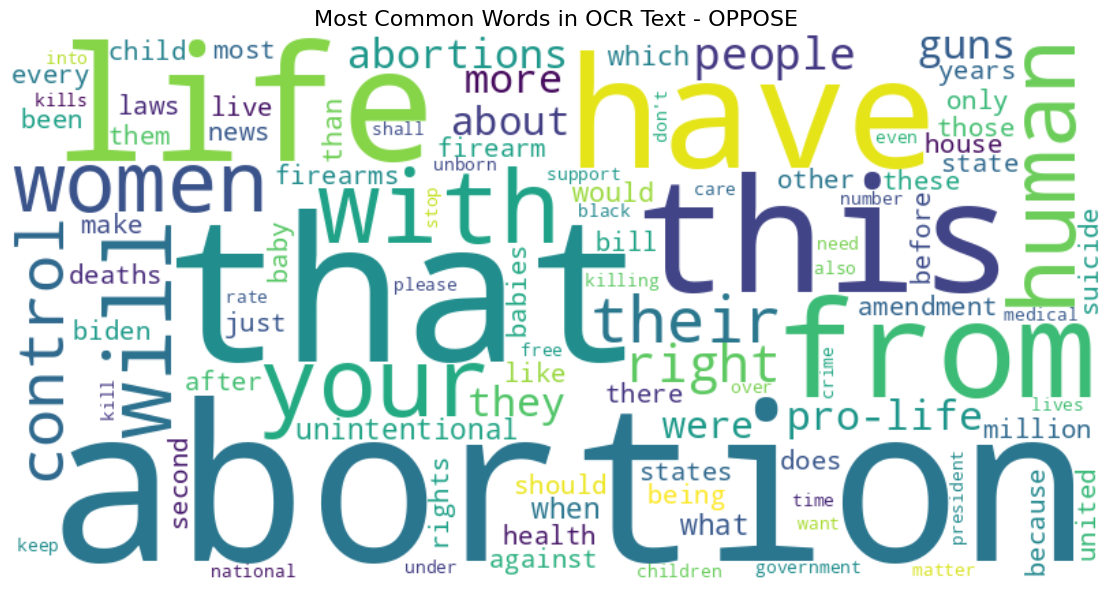

In [11]:
# Text in Images Analysis (OCR)
reader = easyocr.Reader(['en'], gpu=True, verbose=False)

def extract_text_from_image(image_path):

    result = reader.readtext(image_path, paragraph=True)
    if not result:
        return ""
    paragraphs = [text for bbox, text in result]
    formatted_text = "\n".join(paragraphs)
    
    return formatted_text


df_valid['ocr_text'] = df_valid['image_path'].apply(extract_text_from_image)
df_valid['has_text'] = df_valid['ocr_text'].str.len() > 0
df_valid['text_length'] = df_valid['ocr_text'].str.len()


#1. Text Distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Text presence distribution
df_valid['has_text'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['#d62728', '#2ca02c'])
axes[0, 0].set_title('Images with/without Text', fontweight='bold')
axes[0, 0].set_xlabel('Has Text')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticklabels(['No Text', 'Has Text'], rotation=0)

# Text length distribution
df_valid[df_valid['has_text']]['text_length'].hist(bins=50, ax=axes[0, 1], edgecolor='black')
axes[0, 1].set_title('Text Length Distribution (images with text)', fontweight='bold')
axes[0, 1].set_xlabel('Text Length (characters)')
axes[0, 1].set_ylabel('Frequency')

# Text presence by stance
text_stance = df_valid.groupby(['stance', 'has_text']).size().unstack(fill_value=0)
text_stance.plot(kind='bar', ax=axes[1, 0], stacked=False)
axes[1, 0].set_title('Text Presence by Stance', fontweight='bold')
axes[1, 0].set_xlabel('Stance')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend(['No Text', 'Has Text'])
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)

# Text presence by persuasiveness
text_pers = df_valid.groupby(['persuasiveness', 'has_text']).size().unstack(fill_value=0)
text_pers.plot(kind='bar', ax=axes[1, 1], stacked=False)
axes[1, 1].set_title('Text Presence by Persuasiveness', fontweight='bold')
axes[1, 1].set_xlabel('Persuasiveness')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend(['No Text', 'Has Text'])
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '06_ocr_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

#2. WordCloud with most common words (Per Stance)
stances = df_valid['stance'].unique()
for stance in stances:
    text = ' '.join(df_valid[(df_valid['stance']==stance) & (df_valid['has_text'])]['ocr_text'].values)
    words = [w.lower() for w in text.split() if len(w) > 3]
    word_counts = Counter(words)
    
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(word_counts)
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Common Words in OCR Text - {stance.upper()}', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'ocr_wordcloud_{stance}.png'), dpi=300, bbox_inches='tight')
    plt.show()